Load Libraries

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import scipy.misc

import numpy as np
from scipy.misc import imread
import torch
from torchvision import transforms

from sklearn.metrics import confusion_matrix
import seaborn

from model.utils import get_pretrained_model
from model.models import AttributeFCN, AttributeFC, predict_attributes, create_attributes_fcn_model, create_attributes_fc_model, evaluate_model, test_models
from preprocessing.preprocessing import image_loader, load_label_values, get_attribute_dims, train_valid_test_split

label_values_file = "data/label_values.json"
label_values = load_label_values(label_values_file)


#increase size of the plotting
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


use_gpu = torch.cuda.is_available()

image_paths = ['demo_data/test/000023.jpg','demo_data/test/000020.jpg', 'demo_data/test/test_nan_01.png', 'demo_data/test/test_christ_01.png', 'demo_data/test/test_frank_01.png']

TRAIN_IMAGES_FOLDER = 'data/ClothingAttributeDataset/train/'
VALID_IMAGES_FOLDER = 'data/ClothingAttributeDataset/valid/'
TEST_IMAGES_FOLDER = "data/ClothingAttributeDataset/test/"
labels_file = 'data/labels.csv'
label_values_file = 'data/label_values.json'




In [2]:
SOURCE_DATA_DIR = "data/ClothingAttributeDataset/images/"
TARGET_DATA_DIR = "data/ClothingAttributeDataset/"

train_valid_test_split(SOURCE_DATA_DIR, TARGET_DATA_DIR, train_size=0.75, valid_size=0.15)


In [2]:
pretrained_conv_model, _, _ = get_pretrained_model(
    'vgg16', pop_last_pool_layer=True, use_gpu=use_gpu)

target_dims = get_attribute_dims(label_values_file)
attribute_models = create_attributes_fcn_model(
        AttributeFCN,
        512,
        pretrained_conv_model,
        target_dims,
        'weights/fcn/',
        labels_file,
        TRAIN_IMAGES_FOLDER,
        VALID_IMAGES_FOLDER,
        num_epochs=1,
        is_train=False,
        use_gpu=use_gpu)

Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT


In [7]:
#LOAD PRE-TRAINED DENSE MODEL and WEIGHTS
pretrained_conv_model, pretrained_fc, fc_dim = get_pretrained_model(
    'resnet18', pop_last_pool_layer=False, use_gpu=use_gpu)

target_dims = get_attribute_dims(label_values_file)

attribute_models_dense = create_attributes_fc_model(
        AttributeFC,
        pretrained_fc,
        pretrained_conv_model,
        fc_dim,
        target_dims,
        'weights/dnn/',
        labels_file,
        TRAIN_IMAGES_FOLDER,
        VALID_IMAGES_FOLDER,
        num_epochs=1,
        is_train=False,
        use_gpu=use_gpu)

Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT


In [16]:
#EVALUATION RESULT - FCN
eval_results = {}
'''for target, model in attribute_models.items():
    eval_results[target] = evaluate_model(attribute_models[target], pretrained_conv_model, target, 
                                                labels_file,
                                                TEST_IMAGES_FOLDER,
                                                batch_size=32, num_workers=4, 
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False)'''
    
eval_results['category_GT'] = evaluate_model(attribute_models['category_GT'], pretrained_conv_model, 'category_GT', 
                                                labels_file,
                                                TEST_IMAGES_FOLDER,
                                                batch_size=32, num_workers=4, 
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False)
    

In [13]:
category_GT = ['Shirt','Sweater','T-shirt','Outerwear','Suit','Tank Top','Dress']
sleevelength_GT = ['No sleeves', 'Short sleeves','Long sleeves']
neckline_GT = ['V-shape', 'Round','Other shapes']
pattern_GT = ['Floral','Graphics','Plaid','Stripe','Solid','Spot']
skin_exposure_GT = ['null', 'sees high skin exposure']
collar_GT = ['null', 'Has Collar']
gender_GT = ['Is Male', 'Is Female']
scarf_GT = ['null', 'Wears Scarf']
necktie_GT = ['null', 'Wears Necktie']
placket_GT = ['null', 'Has Placket']

category_GT
[ 4.  3.  4.  5.  1.  3.  4.  6.  4.  6.  4.  0.  3.  4.  0.  1.  1.  6.
  0.  1.  3.  2.  0.  1.  6.  4.  3.  6.  3.  1.  4.  6.  1.  6.  4.  2.
  0.  4.  6.  1.  3.  4.  3.  3.  6.  3.  3.  1.  1.  3.  5.  3.  6.  4.
  4.  6.  0.  3.  4.  3.  4.  0.  5.  3.]
[ 0.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  0.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  0.  6.  6.  6.  0.
  6.  6.  6.  6.  6.  6.  0.  0.  6.  6.]
[[ 1  0  0  0  0  0  6]
 [ 0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0 14]
 [ 3  0  0  0  0  0 12]
 [ 0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0 11]]
Accuracy: 18.75%


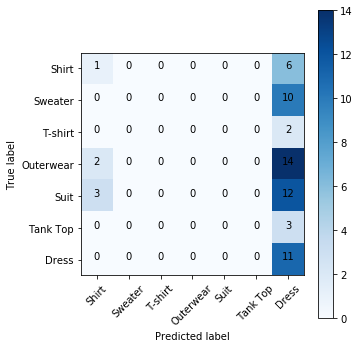

In [19]:
import itertools

#increase size of the plotting
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

for attrib_name, results in eval_results.items():
    print(attrib_name)
    actual = results["y_actual"]
    prediction = results["y_pred"]
    print(actual)
    print(prediction)
    
    classes = category_GT
    
    
    c_m = confusion_matrix(actual, prediction)
    print(c_m)
    np.set_printoptions(precision=2)
    
    print("Accuracy: {:.2%}".format((results["y_pred"] == results["y_actual"]).sum() / len(results["y_pred"])))
    
    plt.figure()
    plt.imshow(c_m, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = c_m.max() / 2.
    for i, j in itertools.product(range(c_m.shape[0]), range(c_m.shape[1])):
        plt.text(j, i, format(c_m[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.savefig('confusion_matrix.png')

In [18]:
#EVALUATION RESULT - DENSE

eval_results_dense = {}
for target, model in attribute_models_dense.items():
    eval_results_dense[target] = evaluate_model(attribute_models_dense[target], pretrained_conv_model, target, 
                                                labels_file,
                                                TEST_IMAGES_FOLDER,
                                                batch_size=32, num_workers=4, 
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False)

RuntimeError: size mismatch, m1: [409600 x 16], m2: [512 x 7] at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/TH/generic/THTensorMath.c:1293

Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
torch.Size([1, 3, 400, 266])
Predicting category_GT
Predicting sleevelength_GT
Predicting neckline_GT
Predicting pattern_GT
Predicting skin_exposure_GT
Predicting collar_GT
Predicting gender_GT
Predicting scarf_GT
Predicting necktie_GT
Predicting placket_GT


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


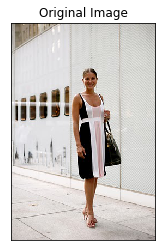

Predicted result:
Catagory: Tank Top, confident: 0.1558002382516861%
Sleeve Length: Short sleeves, confident: 0.3504942059516907%
Neckline: Other shapes, confident: 0.3473201394081116%
Pattern: Spot, confident: 0.18274101614952087%
Skin Exposure: sees high skin exposure, confident: 0.5398668050765991%
Placket: Has Placket, confident: 0.5497504472732544%
Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
torch.Size([1, 3, 400, 266])
Predicting category_GT
Predicting sleevelength_GT
Predicting neckline_GT
Predicting pattern_GT
Predicting skin_exposure_GT
Predicting collar_GT
Predicting gender_GT
Predicting scarf_GT
Predicting necktie_GT
Predicting placket_GT


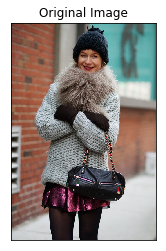

Predicted result:
Catagory: Tank Top, confident: 0.16214390099048615%
Neckline: Other shapes, confident: 0.34132248163223267%
Pattern: Stripe, confident: 0.18436643481254578%
Collar: Has Collar, confident: 0.5381571650505066%
Gender: Is Female, confident: 0.5404240489006042%
Necktie: Wears Necktie, confident: 0.5197188258171082%
Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
torch.Size([1, 3, 400, 266])
Predicting category_GT
Predicting sleevelength_GT
Predicting neckline_GT
Predicting pattern_GT
Predicting skin_exposure_GT
Predicting collar_GT
Predicting gender_GT
Predicting scarf_GT
Predicting necktie_GT
Predicting placket_GT


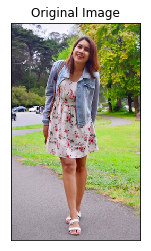

Predicted result:
Catagory: Dress, confident: 0.15904635190963745%
Neckline: Other shapes, confident: 0.348505437374115%
Pattern: Plaid, confident: 0.1709408164024353%
Gender: Is Female, confident: 0.5192042589187622%
Scarf: Wears Scarf, confident: 0.5004125237464905%
Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
torch.Size([1, 3, 400, 266])
Predicting category_GT
Predicting sleevelength_GT
Predicting neckline_GT
Predicting pattern_GT
Predicting skin_exposure_GT
Predicting collar_GT
Predicting gender_GT
Predicting scarf_GT
Predicting necktie_GT
Predicting placket_GT


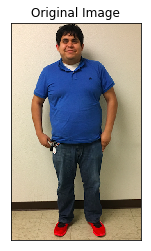

Predicted result:
Catagory: Dress, confident: 0.15211693942546844%
Neckline: Other shapes, confident: 0.36375224590301514%
Pattern: Graphics, confident: 0.1800563484430313%
Collar: Has Collar, confident: 0.5179663300514221%
Gender: Is Female, confident: 0.5081140398979187%
Scarf: Wears Scarf, confident: 0.5178179144859314%
Necktie: Wears Necktie, confident: 0.5355204939842224%
Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
torch.Size([1, 3, 400, 266])
Predicting category_GT
Predicting sleevelength_GT
Predicting neckline_GT
Predicting pattern_GT
Predicting skin_exposure_GT
Predicting collar_GT
Predicting gender_GT
Predicting scarf_GT
Predicting necktie_GT
Predicting placket_GT


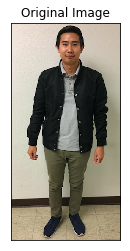

Predicted result:
Catagory: Sweater, confident: 0.15533243119716644%
Pattern: Graphics, confident: 0.17646007239818573%
Collar: Has Collar, confident: 0.5049038529396057%
Scarf: Wears Scarf, confident: 0.5243123769760132%


In [37]:


    
for image_path in image_paths:
    
    pretrained_conv_model, _, _ = get_pretrained_model(
    'vgg16', pop_last_pool_layer=True, use_gpu=use_gpu)

    target_dims = get_attribute_dims(label_values_file)
    attribute_models = create_attributes_fcn_model(
        AttributeFCN,
        512,
        pretrained_conv_model,
        target_dims,
        'weights/fcn/',
        labels_file,
        TRAIN_IMAGES_FOLDER,
        VALID_IMAGES_FOLDER,
        num_epochs=1,
        is_train=False,
        use_gpu=use_gpu)

    
    results = predict_attributes(
        image_path,
        pretrained_conv_model,
        attribute_models,
        flatten_pretrained_out=False)
    
    #Show original Image
    original_img = imread(image_path)
    plt.subplot(121)
    plt.imshow(original_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.show()

    print('Predicted result:')
    for key in results:
        if(key == 'category_GT'):
            result = results[key]
            print('Catagory: {}, confident: {}%'.format(category_GT[result[0]], result[1]))
        if(key == 'sleevelength_GT'):
            result = results[key]
            print('Sleeve Length: {}, confident: {}%'.format(sleevelength_GT[result[0]], result[1]))
        if(key == 'neckline_GT'):
            result = results[key]
            print('Neckline: {}, confident: {}%'.format(neckline_GT[result[0]], result[1]))
        if(key == 'pattern_GT'):
            result = results[key]
            print('Pattern: {}, confident: {}%'.format(pattern_GT[result[0]], result[1]))
        if(key == 'skin_exposure_GT'):
            result = results[key]
            print('Skin Exposure: {}, confident: {}%'.format(skin_exposure_GT[result[0]], result[1]))
        if(key == 'collar_GT'):
            result = results[key]
            print('Collar: {}, confident: {}%'.format(collar_GT[result[0]], result[1]))
        if(key == 'gender_GT'):
            result = results[key]
            print('Gender: {}, confident: {}%'.format(gender_GT[result[0]], result[1]))
        if(key == 'scarf_GT'):
            result = results[key]
            print('Scarf: {}, confident: {}%'.format(scarf_GT[result[0]], result[1]))
        if(key == 'necktie_GT'):
            result = results[key]
            print('Necktie: {}, confident: {}%'.format(necktie_GT[result[0]], result[1]))
        if(key == 'placket_GT'):
            result = results[key]
            print('Placket: {}, confident: {}%'.format(placket_GT[result[0]], result[1]))
    


Processing Attribute: category_GT
Processing Attribute: sleevelength_GT
Processing Attribute: neckline_GT
Processing Attribute: pattern_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: collar_GT
Processing Attribute: gender_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


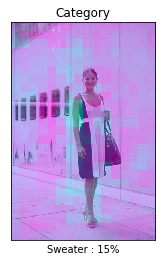

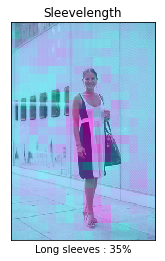

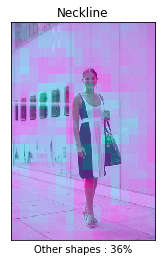

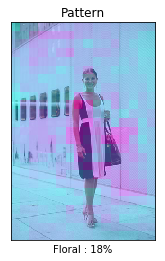

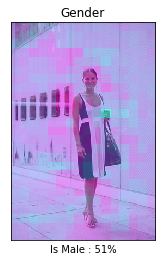

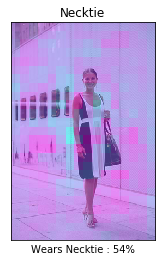

In [39]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

image_url = 'demo_data/test/000023.jpg'

pretrained_conv_model, _, _ = get_pretrained_model(
    'vgg16', pop_last_pool_layer=True, use_gpu=use_gpu)

target_dims = get_attribute_dims(label_values_file)
attribute_models = create_attributes_fcn_model(
        AttributeFCN,
        512,
        pretrained_conv_model,
        target_dims,
        'weights/fcn/',
        labels_file,
        TRAIN_IMAGES_FOLDER,
        VALID_IMAGES_FOLDER,
        num_epochs=1,
        is_train=False,
        use_gpu=use_gpu)

results = test_models(attribute_models, pretrained_conv_model, image_url,
                      attribute_idx_map=label_values["idx_to_names"], return_last_conv_layer=True)

for attrib_name, values in results.items():
    
    test_img = scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266))
    
    plt.imshow(test_img)
    plt.imshow(scipy.misc.imresize(values["conv_layer"], (400, 266), interp='nearest'), 
               alpha=0.5, cmap="cool")
    attrib_name = attrib_name[:-3].capitalize()
    title_prob = "{:.0%}".format(values["pred_prob"])
    plt.title(attrib_name)
#     plt.axis("image")
    plt.yticks([], [])
    plt.xticks([], [])
    plt.xlabel(str(values["pred_class"]) + " : " + title_prob)

    plt.show()
    
    

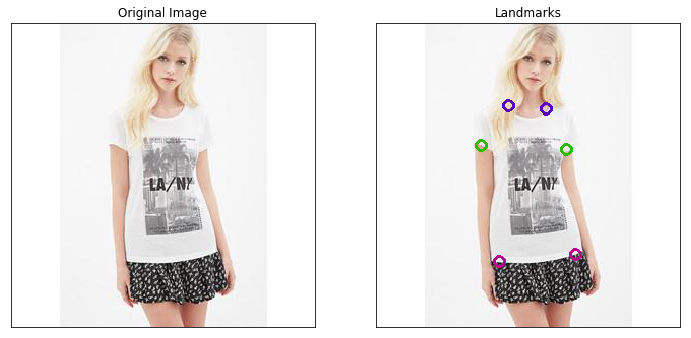

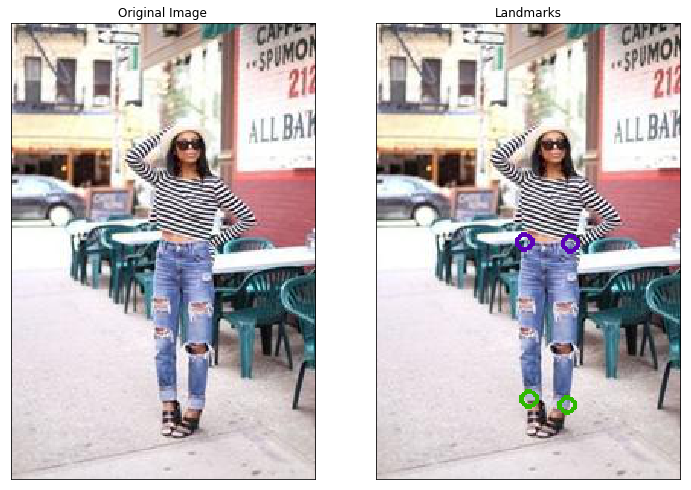

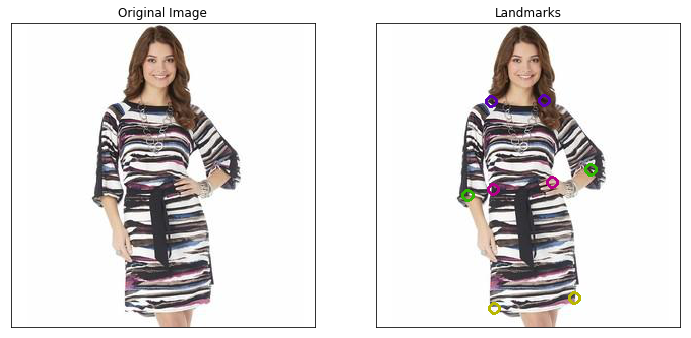

In [10]:
#Fashion Landmarks

def show_sample_image(img, label):
    original_img = cv2.imread(img)
    result_img = cv2.imread(img)
    n = len(label)
    c = 0
    check = 0
    for i in range(0, n, 2):
        x = label[i]
        y = label[i+1]
        cv2.circle(result_img, (x, y), 5, color[c], thickness=2)
        if check%2 != 0:
            c = c+1
        check = check+1
    #Show original Image
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    #Show original Image
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Landmarks'), plt.xticks([]), plt.yticks([])

    plt.show()

color = [(184, 0, 92),(0, 184, 46),(138, 0, 184),(0, 184, 184),(255, 255, 102),(255, 102, 0),(51, 51, 255)]
imgs = ['demo_data/img_00000005.jpg', 
        'demo_data/img_00000060.jpg',  
        'demo_data/img_00000004.jpg'
       ]
labels = [[130, 82, 167, 85, 103, 121, 187, 125, 121, 235, 196, 228], 
          [97,144,127,145,100,247,125,251], 
          [113,78,165,77,90,170,211,145,115,164,173,157,116,281,195,271 ]
         ]


for i in range(len(imgs)):
    show_sample_image(imgs[i], labels[i])

